In [1]:
from data import Data
import numpy as np
from matplotlib import pyplot as plt
import itertools
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
d = Data(first=600, x_transpose=(0, 3, 1, 2))
X_train,y_train = d.get_train()
X_cross, y_cross = d.get_dev()
X_test,y_test = d.get_test()

loaded 100
loaded 200
loaded 300
loaded 400
loaded 500
loaded 600
loaded 700
loaded 800
loaded 900
loaded 1000
loaded 1100
loaded 1200


In [3]:
y_train = y_train
print(X_train.shape)
print(y_train.shape)
print(X_cross.shape)
print(y_cross.shape)
print(X_test.shape)
print(y_test.shape)

(637, 3, 224, 224)
(637,)
(196, 3, 224, 224)
(196,)
(147, 3, 224, 224)
(147,)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.models as models

USE_GPU = True
if USE_GPU:
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

In [5]:
def flatten(X):
    N = X.shape[0]
    return X.view(N,-1)

In [6]:
class Flatten(nn.Module):
    def forward(self, x): 
        return flatten(x)

In [7]:
class MyCustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        img = self.X[index]
        label = self.y[index]
        return (img, label)

    def __len__(self):
        return self.X.shape[0]

In [8]:
NUM_TRAIN = X_train.shape[0]
train_dataset = MyCustomDataset(X_train, y_train)
loader_train = DataLoader(train_dataset, batch_size=20,sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cross_dataset = MyCustomDataset(X_cross, y_cross)
loader_cross = DataLoader(cross_dataset, batch_size=20)

In [9]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            scores = model(Variable(x.float().type(dtypeFloat)))
            _, preds = scores.max(1)
            num_correct += (preds == Variable(y.long().type(dtypeLong))).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [10]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    print(img.shape)
    img = img.transpose(1,2,0)
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [11]:
print_every = 50
print_acc_every = 150
show_transformations = False

def train(m, optimizer, epochs=15):
    loss_arr = []
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            m.train()
            
            scores = m(Variable(x.float().type(dtypeFloat)))
            loss = F.cross_entropy(scores, Variable(y.long().type(dtypeLong)))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss))
                loss_arr += [loss.item()]
                if (t % print_acc_every == 0):
                    print ("train acc:")
                    check_accuracy(loader_train, m)
                    print ("cross acc:")
                    m.eval()
                    check_accuracy(loader_cross, m)
                    
                    # print transformations
                    if show_transformations:
                        x_ = x[5][None]
                        stn = next(m.modules())[0]
                        plt.subplot(1, 2, 1)
                        i = 50
                        imshow_noax(x_.data.numpy()[0], normalize=False)
                        plt.subplot(1, 2, 2)
                        stn_out = stn(Variable(x_.float().type(dtypeFloat))).data.numpy()[0]
                        imshow_noax(stn_out, normalize=False)
                        plt.show()
                    
    return loss_arr

In [15]:
n_class=2
kernel_size =1 
stride =1
class FeatureExtraction(nn.Module):
    def __init__(self):
        super(FeatureExtraction, self).__init__()
        
        # Download and load the pretrained SqueezeNet model. 
        squeeze_model = models.squeezenet1_1(pretrained=True)

        # https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4
        
        # How many In_channels are there for the conv layer
        in_ftrs = squeeze_model.classifier[1].in_channels
        
        # How many Out_channels are there for the conv layer
        out_ftrs = squeeze_model.classifier[1].out_channels
        
        # Converting a sequential layer to list of layers 
        features = list(squeeze_model.classifier.children())
        
        # Changing the conv layer to required dimension
        features[1] = nn.Conv2d(in_ftrs, n_class, kernel_size, stride)
        
        # Changing the pooling layer as per the architecture output
        features[3] = nn.AvgPool2d(13, stride=1)
        
        # Making a container to list all the layers
        squeeze_model.classifier = nn.Sequential(*features)
        
        # Mentioning the number of out_put classes
        squeeze_model.num_classes = n_class        

        self.model = squeeze_model
        
    def forward(self, x):
        return self.model(x)

In [13]:
attn_channel_1 = 4
attn_channel_2 = 10
attn_channel_3 = 10
attn_channel_4 = 10
attn_channel_5 = 8

# https://pytorch.org/tutorials/intermediate/spatial_transformer_tutorial.html
class STN(nn.Module):
    def __init__(self):
        super(STN, self).__init__()
        self.localization = nn.Sequential(
            nn.Conv2d(3, attn_channel_1, 5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(attn_channel_1, attn_channel_2, 3, stride=1, padding=1),
#             nn.Conv2d(attn_channel_2, attn_channel_3, 3, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
#             nn.Conv2d(attn_channel_3, attn_channel_4, 3, stride=1, padding=1),
#             nn.Conv2d(attn_channel_4, attn_channel_5, 3, stride=1, padding=1),
#             nn.MaxPool2d(2),
#             nn.ReLU()
        )
        self.fc_loc = nn.Sequential(
            nn.Linear(attn_channel_3 * 32 * 32, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
    
    def forward(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, attn_channel_3 * 32 * 32)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
    
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
    
        return x

/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Iteration 0, loss = 15.3284
train acc:
Got 333 / 637 correct (52.28)
cross acc:
Got 90 / 196 correct (45.92)
Iteration 0, loss = 0.7296
train acc:
Got 346 / 637 correct (54.32)
cross acc:
Got 94 / 196 correct (47.96)
Iteration 0, loss = 0.6725
train acc:
Got 345 / 637 correct (54.16)
cross acc:
Got 95 / 196 correct (48.47)
Iteration 0, loss = 0.7915
train acc:
Got 354 / 637 correct (55.57)
cross acc:
Got 92 / 196 correct (46.94)
Iteration 0, loss = 0.3892
train acc:
Got 374 / 637 correct (58.71)
cross acc:
Got 102 / 196 correct (52.04)
Iteration 0, loss = 0.4234
train acc:
Got 359 / 637 correct (56.36)
cross acc:
Got 97 / 196 correct (49.49)
Iteration 0, loss = 0.3254
train acc:
Got 432 / 637 correct (67.82)
cross acc:
Got 119 / 196 correct (60.71)
Iteration 0, loss = 0.3411
train acc:
Got 447 / 637 correct (70.17)
cross acc:
Got 119 / 196 correct (60.71)
Iteration 0, loss = 0.2364
train acc:
Got 547 / 637 correct (85.87)
cross acc:
Got 144 / 196 correct (73.47)
Iteration 0, loss = 0.5

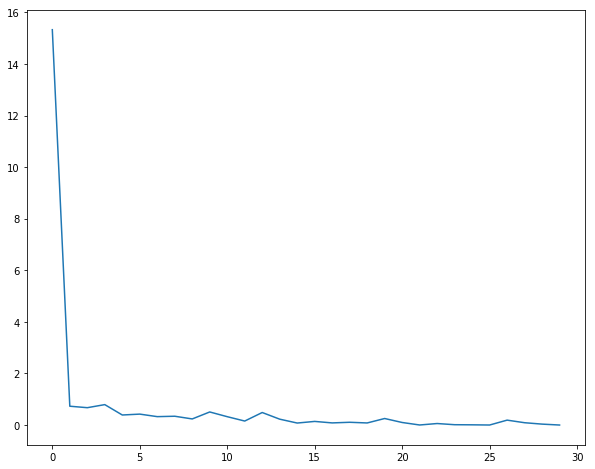

In [14]:
channel_1 = 16
channel_2 = 32
channel_3 = 50
channel_4 = 75
channel_5 = 50
channel_6 = 50
channel_7 = 50
learning_rate = 2.2e-4
num_classes = 2

model = nn.Sequential(
    FeatureExtraction(),
    #     STN(),
#     nn.Conv2d(3, channel_1, 5, padding=2),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(channel_1, channel_2, 3, padding=1),
#     nn.Conv2d(channel_2, channel_3, 3, padding=1),
#     torch.nn.Dropout2d(p=0.5),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(channel_3, channel_4, 3, padding=1),
#     nn.Conv2d(channel_4, channel_5, 3, padding=1),
#     torch.nn.Dropout2d(p=0.5),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     nn.Conv2d(channel_5, channel_6, 3, padding=1),
#     nn.Conv2d(channel_6, channel_7, 3, padding=1),
#     torch.nn.Dropout2d(p=0.5),
#     nn.MaxPool2d(2),
#     Flatten(),
#     nn.Linear(channel_7 * 8 * 8, num_classes)
)
if USE_GPU:
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_arr = train(model, optimizer, 30)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.plot(loss_arr)
plt.show()